In [276]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 

In [123]:
label_encoder = None 

def get_np_array(file_name):
    global label_encoder
    label_encoder = None
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if(label_encoder is None):
        label_encoder = OrdinalEncoder()
        label_encoder.fit(data[need_label_encoding])
    mapping = label_encoder.categories_ # list of arrays
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    v1 = X.to_numpy()
    v2 = y.to_numpy()
    return (v1,v2, mapping)


In [284]:
X_train, Y_train, train_mapping = get_np_array("../data/train.csv") 
X_test, Y_test, test_mapping = get_np_array("../data/test.csv") 
# print((test_mapping)) 
to_extend = [ np.array([], dtype="int64"), np.array([0,1], dtype="int64"), np.array([0,1], dtype="int64"), 
             np.array([0,1], dtype="int64"), np.array([], dtype="int64"), np.array([], dtype="int64"), 
             np.array([], dtype="int64")]
train_mapping.extend( to_extend )
test_mapping.extend(to_extend) 
# print((test_mapping)) 
print((test_mapping)) 
print((train_mapping))

[array(['afganistan', 'australia', 'bangladesh', 'bermuda', 'canada',
       'england', 'india', 'ireland', 'kenya', 'netherlands',
       'new_zealand', 'pakistan', 'scotland', 'south_africa', 'sri_lanka',
       'uae', 'usa', 'west_indis', 'zimbambave'], dtype=object), array(['australia', 'bangladesh', 'bermuda', 'canada', 'england', 'india',
       'ireland', 'kenya', 'malaysia', 'netherlands', 'new_zealand',
       'pakistan', 'scotland', 'south_africa', 'sri_lanka', 'uae', 'usa',
       'west_indis', 'zimbambave'], dtype=object), array(['afganistan', 'australia', 'bangladesh', 'bermuda', 'canada',
       'england', 'india', 'ireland', 'kenya', 'netherlands',
       'new_zealand', 'pakistan', 'scotland', 'south_africa', 'sri_lanka',
       'uae', 'usa', 'west_indis', 'zimbambave'], dtype=object), array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep'], dtype=object), array([0, 1, 2], dtype=int64), array([], dtype=int64), array([0, 1], dtype

In [160]:
class DTNode:

    def __init__(self, depth, features, labels, is_leaf = False, value = 0, column = None):

        #to split on column
        self.depth = depth
        self.features = features
        self.labels = labels
        #add children afterwards
        self.children = None
        # dict to get child idx from attribute value 
        self.get_idx = dict()

        #if leaf then also need value
        self.is_leaf = is_leaf
        if(self.is_leaf):
            self.value = value
        
        if(not self.is_leaf):
            self.column = column
        
        # valid only for cont attr
        self.median = None 
        
        # print(f"made new node with {features.shape[0]} data entries, and depth {depth}") 

def transform(x) : return x*math.log2(x)  

In [270]:
class DTTree:

    def __init__(self):
        #Tree root should be DTNode
        self.root = None       

    def fit(self, X, y, types, mapping, max_depth = 10):
        self.type = types
        # self.x = self.convert_to_int(X)  
        self.x = X 
        self.y = y[:, 0]  # each element of y is a list 
        # print("y is ", self.y) 
        self.mapping = mapping 
        self.max_depth = max_depth

        self.root = self.grow_tree(self.x, self.y, 0) 
        print("training complete") 

    def find_entropy(self, features, labels): # finds H[labels] 
        counts = np.unique(labels, return_counts=True)[1] 
        # print(counts) 
        if (counts.shape[0] == 0): print("empty labels array")  
        counts = counts / (labels.shape[0]) 
        entropy =  -1 * np.sum(np.vectorize(transform)(counts)) 
        return entropy 

    def find_conditional_entropy(self, features, labels, attribute): # finds H[labels | attribute] 
        # speed this up afterwards
        entropy = 0 
        total_size = features.shape[0]
        split_domain = [] 
        if (self.type[attribute] == "cat"):
            attribute_vals = np.unique(features[:, attribute])
            # print(f"for attribute {attribute} values are {attribute_vals}")  
            # no_of_attribute_vals = no_of_attribute_vals.shape[0] 
            for i in attribute_vals:
                new_features = features[features[:, attribute] == i] 
                new_labels = labels[features[:, attribute] == i]
                split_domain.append((i, new_features, new_labels)) 
                size = new_features.shape[0] 
                # print(f"attribute is {attribute}, value is {i} ", end=" ") 
                entropy += (size/total_size) * self.find_entropy(new_features, new_labels) 
        
        else:
            sorted_indices = np.argsort(features[:, attribute]) 
            # print("sorted array is ", features[sorted_indices, attribute]) 
            split_idx = (features.shape[0] - 1)//2 
            median_val = (features[sorted_indices])[split_idx, attribute]  
            # feature_1 = (features[sorted_indices])[: split_idx + 1] 
            # labels_1 = (labels[sorted_indices])[:split_idx + 1] 

            # feature_2 = (features[sorted_indices])[split_idx + 1:] 
            # labels_2 = (labels[sorted_indices])[split_idx + 1:] 

            feature_1 = features[features[:, attribute] <= median_val] 
            labels_1 = labels[features[:, attribute] <= median_val] 

            feature_2 = features[features[:, attribute] > median_val]
            labels_2 = labels[features[:, attribute] > median_val]  

            # print("median is ", median_val) 
            # print(feature_1[:, attribute])
            # print(feature_2[:, attribute])

            if (feature_1.shape[0] > 0) : 
                split_domain.append((median_val, feature_1, labels_1)) 
                entropy += (feature_1.shape[0]/total_size) * self.find_entropy(feature_1, labels_1)
            if (feature_2.shape[0] > 0):
                split_domain.append((median_val, feature_2, labels_2)) 
                entropy += (feature_2.shape[0]/total_size) * self.find_entropy(feature_2, labels_2)
            # print(f"attribute is {attribute}, median is {median_val} ", end=" ")

        
        
        return (entropy, split_domain)   

    def find_split_attribute(self, features, labels):
        max_gain = -1 
        split_attribute = None 
        init_entropy = self.find_entropy(features, labels)
        split_domain = None
        if (len(features.shape) < 2): print("invalid shape found ", features)
        for attribute in range(features.shape[1]):
            conditional_entropy, split = self.find_conditional_entropy(features, labels, attribute) 
            gain = init_entropy - conditional_entropy 
            if (gain > max_gain ): # case of equality and max_gain = 0 
                max_gain = gain 
                split_attribute = attribute 
                split_domain = split 
        return (split_attribute, split_domain) 
    
    def grow_tree(self, features, labels, depth): # returns a DTNode 
        node = DTNode(depth, features, labels)  
        # set is_leaf, value, column 

        y_count = np.unique(labels).shape[0] 
        if (y_count == 1):
            # terminate 
            # print("terminating coz all y same")
            node.is_leaf = True 
            node.value = self.leaf_prediction(node)  
            return node 
        
        if (depth == self.max_depth):
            # terminate 
            # print("terminating coz of depth")
            node.is_leaf = True 
            node.value = self.leaf_prediction(node)
            return node 
        
        
        # else build tree 
        # find attribute first 
        attribute, split_domain = self.find_split_attribute(features, labels)
        
        if (split_domain == None or len(split_domain) == 1):
            # terminate 
            node.is_leaf = True 
            node.value = self.leaf_prediction(node) 
            return node 

        # print("split on ", attribute)
        # print()
        node.is_leaf = False 
        node.column = attribute 
        children = [] 

        # find children of node
        for attr_val, split_features, split_labels in split_domain : 
            child = self.grow_tree(split_features, split_labels, depth + 1) 
            children.append((attr_val,child))  
            node.get_idx[attr_val] = len(children) - 1 
        node.children = np.array(children)   

        # if (self.type[attribute] == "cat"):
        #     for i in range(node.children.shape[0]):
        #         if (i != node.get_idx[node.children[i][0]]):
        #             print("i and node.children[i][0] ", i, node.children[i][0]) 
        #             assert(False) 
        #     assert(len(node.get_idx) == len(node.children)) 
        
        return node 
    
    def leaf_prediction(self, node):
        label_vals, counts = np.unique(node.labels, return_counts=True)
        return label_vals[np.argmax(counts)]   

    def predict(self, features, node, mapping):
        if (node.is_leaf): 
            # print(f"leaf found ..... returning {node.value}")
            return node.value 
        else:
            attribute = node.column
            if (self.type[attribute] == "cat"):
                # print(f"cat attribute {attribute}") 
                attribute_name = mapping[attribute][int(features[attribute])]
                # print(f"value for {attribute} is {attribute_name} for test")   
                train_att_vals = self.mapping[attribute] 
                idx = -1 
                for i in range(len(train_att_vals)):
                    if (train_att_vals[i] == attribute_name): 
                        idx = i 
                        break 
                
                if (idx == -1): # terminate 
                    # print(f"value for {attribute} for train found is invalid")
                    return self.leaf_prediction(node) 
                else:
                    if idx in node.get_idx:
                        # print(f"value for {attribute} for train found is {idx}")
                        child_idx = node.get_idx[idx] 
                        assert(node.children[child_idx][0] == idx) 
                        return self.predict(features, node.children[child_idx][1],mapping)  
                    else:
                        # print(f"value for {attribute} not found among children, need {idx} ")
                        # print(features)
                        for val,child in node.children:
                            assert(val != idx) 
                            # print(val, end=" ")
                        # print()
                        return self.leaf_prediction(node) # terminate 

               
            else:
                # print(f"cont attribute {attribute}") 
                
                attribute_val = features[attribute] 
                median = node.children[0][0] 
                if (attribute_val <= median) : return self.predict(features, node.children[0][1], mapping) 
                else: return self.predict(features, node.children[1][1], mapping)
                
                # if (attribute_val == median):
                #     sorted_indices = np.argsort(node.features[:, attribute]) 
                #     copy = node.features[sorted_indices] 
                #     idx = 0
                #     for i in copy:
                #         if (np.array_equal(i, features)):
                #             break 
                #         idx += 1 
                #     if (idx == copy.shape[0]): 
                #         print("new feature found ?")
                #         return self.leaf_prediction(node) 
                #     split_idx = (node.features.shape[0] - 1 )//2  
                #     if (idx <= split_idx): return self.predict(features, node.children[0][1], mapping)
                #     else : return self.predict(features, node.children[1][1], mapping)
                
                

    def __call__(self, X, mapping):
        '''
        Predicted classes for X
        Args:
            X: numpy array of data [num_samples, num_features]
        Returns:
            y: [num_samples, 1] predicted classes
        '''
        
        predictions = [] 
        for features in X:
            predictions.append(self.predict(features, self.root, mapping)) 
        return np.array(predictions)

    def compute_accuracy(self, predictions, labels):
        labels = labels[:,0] # labels is a list of list 
        checks = (predictions == labels)
        # print(checks.shape[0]) 
        # print(checks)
        correct = np.count_nonzero(checks) 
        print(f"Correct : {correct}") 
        print(f"Incorrect : {labels.shape[0] - correct}") 
        return correct/labels.shape[0] 
    
    def check_split(self, node):
        ans = True 
        sum = 0 
        if (node.is_leaf): return True 
        for val,child in node.children:
            temp = self.check_split(child) 
            ans = temp 
            sum += child.features.shape[0]
        if (ans == False): return ans 
        if (sum == node.features.shape[0]): return True 
        else: return False  
    
    def post_prune(self, X_val, y_val):
        return
        #TODO

In [281]:
types = ['cat','cat','cat',"cat","cat","cont","cat","cat","cat" ,"cont","cont" ,"cont" ]

decision_tree_classifier = DTTree() 
depths = [5,10,15,20,25] 
train = [] 
test = [] 
for depth in depths:
    decision_tree_classifier.fit(X_train, Y_train,types,train_mapping, depth) 
    print(f"depth is {depth}")
    
    predictions = decision_tree_classifier(X_train, train_mapping) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_train) 
    train.append(accuracy * 100)
    print(f"train accuracy is {accuracy}" ) 
    
    predictions = decision_tree_classifier(X_test, test_mapping) 
    accuracy = decision_tree_classifier.compute_accuracy(predictions, Y_test) 
    test.append(accuracy * 100)
    print(f"test accuracy is {accuracy}" )
    print() 

training complete
depth is 5
Correct : 6932
Incorrect : 895
train accuracy is 0.8856522294621183
Correct : 556
Incorrect : 411
test accuracy is 0.5749741468459152

training complete
depth is 10
Correct : 7798
Incorrect : 29
train accuracy is 0.9962948767088284
Correct : 578
Incorrect : 389
test accuracy is 0.5977249224405378

training complete
depth is 15
Correct : 7803
Incorrect : 24
train accuracy is 0.9969336910693752
Correct : 578
Incorrect : 389
test accuracy is 0.5977249224405378

training complete
depth is 20
Correct : 7803
Incorrect : 24
train accuracy is 0.9969336910693752
Correct : 578
Incorrect : 389
test accuracy is 0.5977249224405378

training complete
depth is 25
Correct : 7803
Incorrect : 24
train accuracy is 0.9969336910693752
Correct : 578
Incorrect : 389
test accuracy is 0.5977249224405378



In [279]:
def plot_accuracies(test, train, depths, name):
    fig,axis = plt.subplots()
    axis.plot(depths, test, label="test accuracy")
    axis.plot(depths, train, label="train accuracy")
    axis.set_xlabel("depth")
    axis.set_ylabel("accuracy")
    axis.legend()
    plt.savefig(f"{name}.png")
    plt.show()

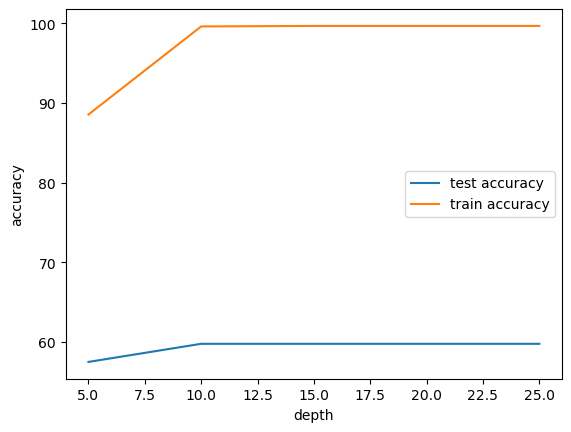

In [282]:
plot_accuracies(test, train, depths, "1.a)")

In [283]:
# all win predictor, all loss predictor 
all_win_predictions = [1] * X_train.shape[0] 
all_loss_predictions = [0] * X_train.shape[0]
print(f"all win accuracy for train is {decision_tree_classifier.compute_accuracy(all_win_predictions, Y_train)}")
print(f"all loss accuracy for train is {decision_tree_classifier.compute_accuracy(all_loss_predictions, Y_train)}")

all_win_predictions = [1] * X_test.shape[0] 
all_loss_predictions = [0] * X_test.shape[0]
print(f"all win accuracy for test is {decision_tree_classifier.compute_accuracy(all_win_predictions, Y_test)}")
print(f"all loss accuracy test is {decision_tree_classifier.compute_accuracy(all_loss_predictions, Y_test)}")


Correct : 3940
Incorrect : 3887
all win accuracy for train is 0.5033857161108982
Correct : 3887
Incorrect : 3940
all loss accuracy for train is 0.49661428388910184
Correct : 480
Incorrect : 487
all win accuracy for test is 0.4963805584281282
Correct : 487
Incorrect : 480
all loss accuracy test is 0.5036194415718718


# One hot encoding

In [291]:
def get_np_array2(file_name):
    global label_encoder
    label_encoder = None 
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if(label_encoder is None):
        label_encoder = OneHotEncoder(sparse_output = False)
        label_encoder.fit(data[need_label_encoding])
    mapping = label_encoder.categories_ # list of arrays
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return (X.to_numpy(), y.to_numpy(), mapping)


In [301]:
train_mapping = []
test_mapping = []
X_test, Y_test, test_mapping = get_np_array2("../data/test.csv") 
X_train, Y_train, train_mapping = get_np_array2("../data/train.csv") 

copy1 = [] 
for arr in test_mapping:
    for j in range(len(arr)) : 
        copy1.append(np.array([0,1], dtype="int64"))
    
copy2= [] 
for arr in test_mapping:
    for j in range(len(arr)) : 
        copy2.append(np.array([0,1], dtype="int64"))

to_extend = [ np.array([], dtype="int64"), np.array([0,1], dtype="int64"), np.array([0,1], dtype="int64"), 
             np.array([0,1], dtype="int64"), np.array([], dtype="int64"), np.array([], dtype="int64"), 
             np.array([], dtype="int64")]
train_mapping.extend( to_extend )
copy1.extend(to_extend) 
copy2.extend(to_extend)
print(len(copy1), len(copy2)) 
# print((test_mapping)) 
# print((train_mapping))
# print(X_test[0])

79 79
